# DF

In [810]:

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from collections import OrderedDict
from CNN_stock.CNN20 import CNN20d
from CNN_stock.image_to_tensor import StockDataset
import intel_extension_for_pytorch as ipex

device = torch.device('xpu')

df = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\stock.pkl')
   
time_windows = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\time_windows.pkl')  
time_windows = time_windows[6:] 
time_windows = time_windows[:-1]

model_paths = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\model_paths.pkl')

# 生成圖片

In [812]:
df['folder_name'] = None

for _, window in time_windows.iterrows():

    trading_start, trading_end = window['trading_period'].split('_')
    trading_start = pd.to_datetime(trading_start)
    trading_end = pd.to_datetime(trading_end)

    mask = (df.index >= trading_start) & (df.index <= trading_end)
    
    df.loc[mask, 'folder_name'] = window['folder_name']
    
df = df.dropna()    

In [817]:
df.index.unique()

DatetimeIndex(['2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29',
               ...
               '2024-09-27', '2024-09-30', '2024-10-01', '2024-10-04',
               '2024-10-07', '2024-10-08', '2024-10-09', '2024-10-11',
               '2024-10-14', '2024-10-15'],
              dtype='datetime64[ns]', name='Date', length=608, freq=None)

In [833]:
base_output_dir = r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\images'

images_dict = []  

os.makedirs(base_output_dir, exist_ok=True)

i = 0
date_range = df.index.unique()
while i < len(date_range) - 21:
    
    generate_date = date_range[i:i+20]
    dataset_create = StockDataset(
        state='create',
        stock_data=df[df.index.isin(generate_date)],
        output_dir=base_output_dir
    )
    image_paths, labels = dataset_create.image_paths, dataset_create.labels

    key = date_range[i+21]  
    value = [(image_paths[j], labels[j]) for j in range(len(image_paths))]
    
    images_dict.append({
        'Trading_Day': key,
        'value': [value]  
    })

    i += 1
    


# Trading Strategy

In [868]:
def H_L_Strategy(predict_with_prod, hold, df, k, H_L=True):
    """
    High minus Low Strategy
    
    Parameters:
    predict_with_prod: DataFrame, predict_with_prod of model
    hold: DataFrame, hold now, ['date','Ticker','share','return']
    df: DataFrame, market price, ['date','Ticker','Adj Close','Open']
    k: int, number of top/bottom stocks to trade
    H_L: bool, whether to consider short selling (default True)
    
    Returns:
    hold: update after change
    capital: capital by now, date
    """
    
    buyTradeCostRate = 0.001425
    sellTradeCostRate = 0.001425 + 0.003

    current_date = df.index[0]
    
    buy_pools = predict_with_prod[:k]['Ticker'].tolist()
    sell_pools = predict_with_prod[-k:]['Ticker'].tolist()
    
    # 清倉
    if not hold.empty:
        hold = hold.merge(df[['Ticker', 'Open']], on='Ticker', how='left')
 
        hold['adjusted_capital'] = hold.apply(
            lambda row: row['share'] * row['Open'] * (1 - sellTradeCostRate) if row['share'] > 0 
            else row['share'] * row['Open'] * (1 + buyTradeCostRate), axis=1
        )
        capital = hold['adjusted_capital'].sum()
        
    else: 
        capital = 1
    
    new_positions = []

    # H_L 為 True，放空
    if H_L:
        short_position_value = capital / len(sell_pools)

        for ticker in sell_pools:
            price = df[df['Ticker'] == ticker]['Adj Close'].iloc[0]
            shares = -short_position_value / (price * (1 + sellTradeCostRate)) 

            new_positions.append({
                'date': current_date,
                'Ticker': ticker,
                'share': shares,
            })
        position_value = 2 * capital / len(buy_pools)
    else:
        position_value = capital / len(buy_pools)
        
    for ticker in buy_pools:
        price = df[df['Ticker'] == ticker]['Adj Close'].iloc[0]
        shares = position_value / (price * (1 - buyTradeCostRate)) 

        new_positions.append({
            'date': current_date,
            'Ticker': ticker,
            'share': shares
        })    
    
    new_hold = pd.DataFrame(new_positions)
    
    return new_hold, [current_date.strftime('%Y-%m-%d'), capital]

def cal_return(df):
    df['H_L_daily_return'] = df['H_L'].pct_change(1)
    df['H_daily_return'] = df['H'].pct_change(1)
    df['H_L_cumulative_return'] = (1 + df['H_L_daily_return']).cumprod()-1
    df['H_cumulative_return'] = (1 + df['H_daily_return']).cumprod()-1
    return df

# CNN

In [821]:
def cnn_predict(tensor_dataset,labels,tickers,adj,model):
    model.eval()
    Ticker_probs = []
    with torch.no_grad():  
        for image ,ticker in zip(tensor_dataset,tickers):
            image = image.unsqueeze(0).to(device)
            output = model(image.to(device))
            probabilities = F.softmax(output, dim=1)
            prob_for_class_1 = probabilities[:, 1].item()
            Ticker_probs.append({'Ticker':ticker,'Prob':prob_for_class_1})
            
        Ticker_probs = pd.DataFrame(Ticker_probs)
        Ticker_probs = pd.merge(Ticker_probs, pd.Series(labels, name="y_true"), left_index=True, right_index=True)
        Ticker_probs = Ticker_probs.sort_values(by = 'Prob',ascending=False)
    return Ticker_probs

# GCN

In [822]:
import torch.nn.functional as F
from pygcn.models import GCN
import scipy.sparse as sp

from pygcn.models import GCN

def gcn_predict(dataset,labels, tickers, adj, model):
    Ticker_probs = []

    flattened_features = []
    for image in dataset: 
        flattened_image = image.view(-1)
        flattened_features.append(flattened_image)

    flattened_features = torch.stack(flattened_features)
    flattened_features = sp.csr_matrix(flattened_features[:,:], dtype=np.float32)
    flattened_features = torch.FloatTensor(np.array(flattened_features.todense()))
    
    model.eval()
    output = model(flattened_features, adj)
    probabilities = F.softmax(output, dim=1)
    prob_for_class_1 = probabilities[:, 1].detach().numpy()
    Ticker_probs = pd.DataFrame({'Ticker': tickers, 'Prob': prob_for_class_1})

    Ticker_probs = pd.DataFrame(Ticker_probs)
    Ticker_probs = pd.merge(Ticker_probs, pd.Series(labels, name="y_true"), left_index=True, right_index=True)
    Ticker_probs = Ticker_probs.sort_values(by='Prob', ascending=False)

    return Ticker_probs

def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float32)

temp = df[['Ticker','Sector']].drop_duplicates(subset='Ticker', keep='first')
ticker_sector_map = temp.set_index('Ticker')['Sector']
sector_array = ticker_sector_map.values
adj_matrix = np.equal.outer(sector_array, sector_array).astype(int)

adj = sp.csr_matrix(np.array(adj_matrix)[:,:],dtype = np.float32)
adj = normalize(adj + sp.eye(adj.shape[0]))
adj = sparse_mx_to_torch_sparse_tensor(adj)

del temp,ticker_sector_map,sector_array,adj_matrix


# Logistic regression

In [823]:

def lg_image_predict(tensor_dataset,labels, tickers,adj, model):
    Ticker_probs = []

    for image, ticker in zip(tensor_dataset, tickers):

        flattened_image = image.view(-1).numpy().reshape(1, -1)

        output = model.predict_proba(flattened_image)

        prob_for_class_1 = output[0, 1]

        Ticker_probs.append({'Ticker': ticker, 'Prob': prob_for_class_1})

    Ticker_probs = pd.DataFrame(Ticker_probs)
    Ticker_probs = pd.merge(Ticker_probs, pd.Series(labels, name="y_true"), left_index=True, right_index=True)
    Ticker_probs = Ticker_probs.sort_values(by='Prob', ascending=False)

    return Ticker_probs



In [824]:
def flatten_price_features(df, window=20):

    df = df.reset_index(drop=True)

    df_flattened = (df
                    .groupby(df.index // window)
                    .apply(lambda x: x.values.flatten())
                    .apply(pd.Series))

    num_columns = len(df.columns)
    df_flattened.columns = [f"{window - 1 - (i // num_columns)}_{df.columns[i % num_columns]}"
                            for i in range(len(df_flattened.columns))]

    df_flattened.index = range(df_flattened.shape[0])

    return df_flattened

def normalize_features(cols_to_process,group):
    min_vals = group[cols_to_process].min()
    max_vals = group[cols_to_process].max()
    return (group[cols_to_process] - min_vals) / (max_vals - min_vals)

def lg_price_predict(df,trading_day,model):
    
    k = df.index.unique()
    indice = k.get_loc(trading_day)
    sample = df[df.index.isin(k[indice-20:indice])]

    Ticker_probs = sample.groupby('Ticker')['y'].last().reset_index()
    Ticker_probs.columns = ['Ticker', 'y_true']

    cols_to_process = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    feature = normalize_features(cols_to_process,sample)

    feature = flatten_price_features(feature, window=20)
    output = models['lg_price_model'][0].predict_proba(feature.values)
    Ticker_probs['Prob'] = output[:,1]

    Ticker_probs = Ticker_probs[['Ticker', 'Prob', 'y_true']]
    Ticker_probs = Ticker_probs.sort_values(by='Prob', ascending=False)
    return Ticker_probs

# Comparsion

In [835]:
images_dict = pd.DataFrame(images_dict)
images_dict = images_dict.set_index('Trading_Day')
images_dict['model_type'] = None

for _, window in time_windows.iterrows():

    trading_start, trading_end = window['trading_period'].split('_')
    trading_start = pd.to_datetime(trading_start)
    trading_end = pd.to_datetime(trading_end)

    mask = (images_dict.index >= trading_start) & (images_dict.index <= trading_end)
    
    images_dict.loc[mask, 'model_type'] = window['folder_name']

In [905]:
import joblib

def load_models_for_trading_period(time_windows, base_output_dir):
    models = {}
    
    for _, window in time_windows.iterrows():
        traning_period = window['folder_name']
        period_model_path = os.path.join(base_output_dir, traning_period)

        cnn_model_path = os.path.join(period_model_path, 'cnn_model.pth')
        gcn_model_path = os.path.join(period_model_path, 'gcn_model.pth')
        lg_iamge_model_path = os.path.join(period_model_path, 'lg_image_model.pkl')
        lg_price_model_path = os.path.join(period_model_path, 'lg_price_model.pkl')     
        
        try:
            cnn_model = CNN20d().to(device) 
            cnn_model.load_state_dict(torch.load(cnn_model_path))
            cnn_model.eval() 
            
            gcn_model = torch.load(gcn_model_path).to("cpu")
            gcn_model.eval() 
            
            lg_iamge_model = joblib.load(lg_iamge_model_path)
            lg_price_model = joblib.load(lg_price_model_path)
            
            models[traning_period] = {
                'cnn_model': cnn_model,
                'lg_image_model': lg_iamge_model,
                'gcn_model':gcn_model,
                'lg_price_model':lg_price_model
            }
            
            print(f"Loaded models for trading period {traning_period}")
        
        except FileNotFoundError:
            print(f"Models not found for trading period {traning_period}")
        except Exception as e:
            print(f"Error loading models for {traning_period}: {e}")
    
    return models

base_input_dir = r"C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models"
models = load_models_for_trading_period(time_windows, base_input_dir)
models = pd.DataFrame(models).T

Loaded models for trading period 2020-04-15_2022-04-15
Loaded models for trading period 2020-07-15_2022-07-15
Loaded models for trading period 2020-10-14_2022-10-14
Loaded models for trading period 2021-01-16_2023-01-16
Loaded models for trading period 2021-04-14_2023-04-14
Loaded models for trading period 2021-07-14_2023-07-14
Loaded models for trading period 2021-10-16_2023-10-16
Loaded models for trading period 2022-01-16_2024-01-16
Loaded models for trading period 2022-04-16_2024-04-16
Loaded models for trading period 2022-07-16_2024-07-16


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from collections import defaultdict
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def initialize_performance_records(models):
    """初始化性能記錄字典，加入top-k指標"""
    performance_records = {
        model: {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'top_k_accuracy': [],      
            'dates': []
        } for model in models
    }
    return performance_records

def evaluate_model_performance(y_true, y_pred, k=10):

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary'),
        'recall': recall_score(y_true, y_pred, average='binary'),
        'f1': f1_score(y_true, y_pred, average='binary')
    }

    top_k_true = y_true[:10]
    y_pred_top_k = np.ones_like(top_k_true)
     
    metrics.update({
        'top_k_accuracy': accuracy_score(top_k_true, y_pred_top_k)
    })
    
    return metrics

models_name = ['lg_image', 'cnn', 'gcn','lg_price']
performance_records = initialize_performance_records(models_name)

for index in tqdm(images_dict.index):
    images_day = pd.DataFrame(images_dict.loc[index]['value'][0])
    image_paths, labels = images_day[0].tolist(), images_day[1].tolist()
    trading_day = index

    dataset = StockDataset(state='transform', image_paths=image_paths, labels=labels)
    tensor_dataset, tickers = dataset.get_tensor_dataset()

    models_config = {
        'lg_image': {
            'predict_func': lg_image_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['lg_image_model']
        },
        'cnn': {
            'predict_func': cnn_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['cnn_model']
        },
        'gcn': {
            'predict_func': gcn_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['gcn_model']
        },
        'lg_price': {
            'predict_func': lg_price_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['lg_price_model']
        }
    }

    
    for model_name, config in models_config.items():
        if model_name == 'lg_price':
            try:
                predictions = config['predict_func'](
                    df=df,
                    trading_day=trading_day,
                    model=config['model']
                )
            except Exception as e:
                print(f"Error processing lg_price for {trading_day}: {str(e)}")
                continue
        else:
            predictions = config['predict_func'](
                tensor_dataset,
                labels,
                tickers,
                adj,
                config['model']
            )

        pred_labels = (predictions['Prob'] > 0.5).astype(int)

        metrics = evaluate_model_performance(
            y_true=predictions['y_true'], 
            y_pred=pred_labels, 
            k=10
        )

        for metric_name, value in metrics.items():
            if metric_name in performance_records[model_name]:
                performance_records[model_name][metric_name].append(value)
            
        performance_records[model_name]['dates'].append(trading_day)

  1%|▏         | 8/587 [00:19<23:51,  2.47s/it]


KeyboardInterrupt: 

In [838]:
summary = {}

for model_name, records in performance_records.items():
    summary[model_name] = {
        metric: {
            'mean': np.mean(values),
            'std': np.std(values),
            'max': np.max(values),
            'min': np.min(values)
        }
        for metric, values in records.items()
        if metric != 'dates'
    }
    
summary_df = pd.DataFrame({
    (model_name, metric): stats
    for model_name, metrics in summary.items()
    for metric, stats in metrics.items()
}).T 

summary_df

mean       std       max       min
lg_image accuracy        0.522772  0.049788  0.757576  0.335498
         precision       0.329582  0.166704  0.927577  0.003774
         recall          0.448486  0.088096  0.736111  0.047619
         f1              0.352469  0.118319  0.728739  0.006993
         top_k_accuracy  0.328450  0.211408  1.000000  0.000000
cnn      accuracy        0.510218  0.103004  0.897186  0.187229
         precision       0.334364  0.170191  0.941767  0.000000
         recall          0.493660  0.216592  0.926702  0.000000
         f1              0.354725  0.142700  0.862113  0.000000
         top_k_accuracy  0.342760  0.227409  1.000000  0.000000
gcn      accuracy        0.551259  0.207894  0.994589  0.029221
         precision       0.201687  0.205764  1.000000  0.000000
         recall          0.346405  0.414461  1.000000  0.000000
         f1              0.199157  0.225290  0.819923  0.000000
         top_k_accuracy  0.333220  0.241736  1.000000  0.000000
lg_price accuracy        0.674075  0.167722  0.994589  0.073593
         precision       0.000000  0.000000  0.000000  0.000000
         recall          0.000000  0.000000  0.000000  0.000000
         f1              0.000000  0.000000  0.000000  0.000000
         top_k_accuracy  0.381431  0.228049  1.000000  0.000000

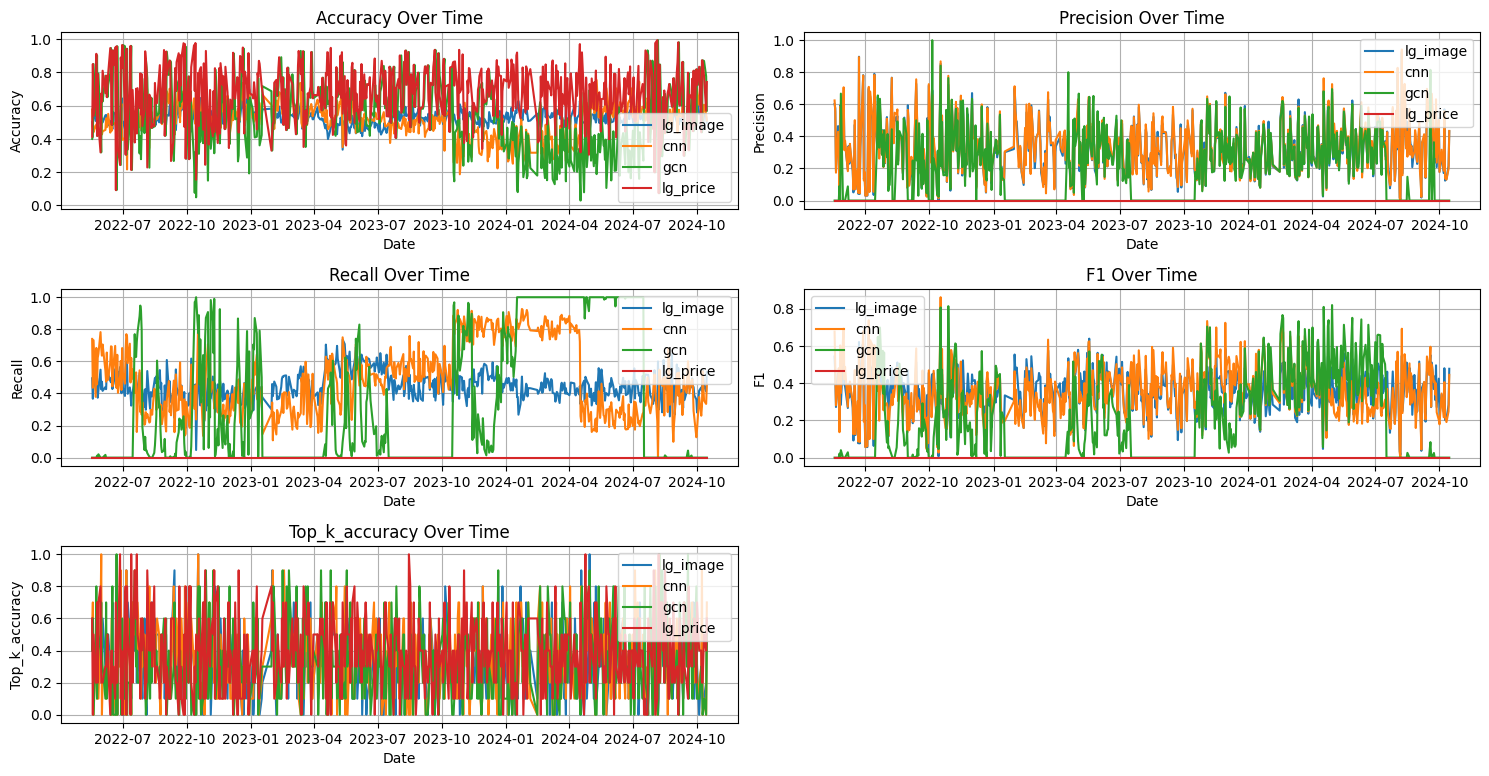

In [839]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1','top_k_accuracy']
for i, metric in enumerate(metrics, 1):
    plt.subplot(4, 2, i)
    for model_name in performance_records.keys():
        dates = performance_records[model_name]['dates']
        values = performance_records[model_name][metric]
        plt.plot(dates, values, label=model_name)
        
    plt.title(f'{metric.capitalize()} Over Time')
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
plt.close()

# Simulation Trading


In [877]:
def initialize_records(models, k_range):
    hold_H_L = {model: {k: pd.DataFrame() for k in k_range} for model in models}
    hold_H = {model: {k: pd.DataFrame() for k in k_range} for model in models}
    hold_records = {model: {k: [] for k in k_range} for model in models}
    capital_records = {model: {k: [] for k in k_range} for model in models}
    return hold_H_L , hold_H , hold_records, capital_records

def model_prediction_and_strategy(model_name, predict_func, tensor_dataset, labels, tickers, adj, model, trading_day, df, hold_H_L, hold_H, hold_records, capital_records, k_range):
    """
    Parameters:
    -----------
    model_name: str
         ('lg_image', 'gcn', 'cnn', 'lg_price')
    predict_func: function
    tensor_dataset: tensor or DataFrame (用於lg_price)
    labels: list
    tickers: list
    adj: matrix
    model: object
    trading_day: datetime
    df: DataFrame
    hold_H_L, hold_H, hold_records, capital_records: dict
    k_range: range
    """

    if model_name == 'lg_price':
        predict_prob = predict_func(
            df=df,
            trading_day=trading_day,
            model=model
        )
    else:
        predict_prob = predict_func(
            tensor_dataset,
            labels,
            tickers,
            adj,
            model
        )

    for k in k_range:
        hold_H_L[model_name][k], cap_H_L = H_L_Strategy(
            predict_prob, 
            hold_H_L[model_name][k], 
            df[df.index.isin([trading_day])], 
            k=k, 
            H_L=True
        )

        hold_H[model_name][k], cap_H = H_L_Strategy(
            predict_prob, 
            hold_H[model_name][k], 
            df[df.index.isin([trading_day])], 
            k=k, 
            H_L=False
        )

        hold_records[model_name][k].append({
            'H_L': hold_H_L[model_name][k],
            'H': hold_H[model_name][k]
        })

        capital_records[model_name][k].append({
            'day': trading_day,
            'H_L': cap_H_L[1],
            'H': cap_H[1]
        })

k_range = range(10, 21)
models_name = ['lg_image', 'cnn', 'gcn', 'lg_price']  


hold_H_L, hold_H, hold_records, capital_records = initialize_records(models_name, k_range)

for index in tqdm(images_dict.index, desc="Processing trades"):
    images_day = pd.DataFrame(images_dict.loc[index]['value'][0])
    image_paths, labels = images_day[0].tolist(), images_day[1].tolist()
    trading_day = index

    dataset = StockDataset(state='transform', image_paths=image_paths, labels=labels)
    tensor_dataset, tickers = dataset.get_tensor_dataset()
    
    models_config = {
        'lg_image': {
            'predict_func': lg_image_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['lg_image_model']
        },
        'cnn': {
            'predict_func': cnn_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['cnn_model']
        },
        'gcn': {
            'predict_func': gcn_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['gcn_model']
        },
        'lg_price': {
            'predict_func': lg_price_predict,
            'model': models.loc[images_dict.loc[index]['model_type']]['lg_price_model']
        }
    }


    for model_name, config in models_config.items():
        model_prediction_and_strategy(
            model_name,              
            config['predict_func'],
            tensor_dataset,
            labels,
            tickers,
            adj,
            config['model'],
            trading_day,
            df,
            hold_H_L,
            hold_H,
            hold_records,
            capital_records,
            k_range
        )

Processing trades: 100%|██████████| 587/587 [27:00<00:00,  2.76s/it]


In [883]:
twii_data = yf.download(tickers="0050.TW", start="2022-04-19", end="2024-10-16")

twii_data = twii_data['Adj Close']
twii_data.index = twii_data.index.tz_localize(None)
twii_data = twii_data[twii_data.index.isin(images_dict.index)]

[*********************100%***********************]  1 of 1 completed


In [919]:
import matplotlib.pyplot as plt

# twii_data = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\tw_index.pkl')
# twii_data = twii_data[twii_data.index.isin(images_dict.index)]

def create_comparison_plots(capital_records, models, k_range, twii_data, output_dir):
    # Create output directories
    same_k_dir = os.path.join(output_dir, 'same_k_comparison')
    same_model_dir = os.path.join(output_dir, 'same_model_comparison')
    os.makedirs(same_k_dir, exist_ok=True)
    os.makedirs(same_model_dir, exist_ok=True)

    
    # Calculate TWII returns
    twii_returns = (twii_data.pct_change(1))['0050.TW']

    # Plot for same k, different models
    linestyles = ['-', '--', ':', '-.']
    for k in k_range:
        plt.figure(figsize=(12, 6))
        for i, model in enumerate(models):
            linestyle = linestyles[i % len(linestyles)]
            df = pd.DataFrame(capital_records[model][k])
            df = cal_return(df)
            sharpe_ratio = df['H_daily_return'].mean()/ df['H_daily_return'].std()
            plt.plot(df['day'], 
             df['H_daily_return'], 
             linestyle=linestyle,
             label=f'H_L{model} (Sharpe={sharpe_ratio:.2f})')

            # plt.plot(df['day'], df['H_cumulative_return'], linestyle=linestyle, label=f'H_{model}')
        
        plt.plot(df['day'], twii_returns, label=f'TW_index (Sharpe = {(twii_returns.mean()/twii_returns.std()):.2f})')
        
        plt.title(f'Model daily return Comparison H (k={k})')
        plt.xlabel('Date')
        plt.ylabel('Net Return')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(same_k_dir, f'k_{k}_comparison.png'))
        plt.close()

    # Plot for same model, different k
    for model in models:
        plt.figure(figsize=(12, 6))
        for k in k_range:
            df = pd.DataFrame(capital_records[model][k])
            df = cal_return(df)
            plt.plot(df['day'], df['H_daily_return'], label=f'H_L_{k}')
            # plt.plot(df['day'], df['H_cumulative_return'], label=f'H_{k}')
        
        plt.title(f'{model} daily return H -  Different k Values')
        plt.xlabel('Date')
        plt.ylabel('Net Return')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(same_model_dir, f'{model}_k_comparison.png'))
        plt.close()

output_dir = r"C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\Comparsion"
models = list(capital_records.keys())  
k_range = range(10, 21)

create_comparison_plots(capital_records, models, k_range, twii_data, output_dir)

In [923]:
import pickle
file_path = r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\hold_records.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(hold_records, file)

In [916]:

cal_return(pd.DataFrame(capital_records['cnn'][10]))

,day,H_L,H,H_L_daily_return,H_daily_return,H_L_cumulative_return,H_cumulative_return
0,2022-05-18,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN
1,2022-05-19,1.049539e+00,1.069523e+00,0.049539,0.069523,4.953855e-02,6.952281e-02
2,2022-05-20,1.176418e+00,1.191312e+00,0.120891,0.113873,1.764185e-01,1.913122e-01
3,2022-05-23,1.227433e+00,1.256478e+00,0.043364,0.054701,2.274330e-01,2.564779e-01
4,2022-05-24,1.344139e+00,1.367518e+00,0.095081,0.088374,3.441391e-01,3.675184e-01
...,...,...,...,...,...,...,...
582,2024-10-08,2.517007e+07,4.714406e+07,0.000411,-0.002022,2.517007e+07,4.714406e+07
583,2024-10-09,2.528287e+07,4.731962e+07,0.004481,0.003724,2.528287e+07,4.731962e+07
584,2024-10-11,2.514022e+07,4.719575e+07,-0.005642,-0.002618,2.514022e+07,4.719575e+07
585,2024-10-14,2.496725e+07,4.706651e+07,-0.006880,-0.002738,2.496725e+07,4.706651e+07


# Sector種類

In [ ]:
sector_info = df[['Ticker','Sector']].drop_duplicates()
sector_counts = []  
for i, model in enumerate(models):
    for k in k_range:
        temp = pd.DataFrame(hold_records[model][k])
        for j in range(len(temp)):
            tickers = temp['H_L'].iloc[j]  
            merged_data = pd.merge(
                pd.DataFrame(tickers),
                sector_info,
                on='Ticker'
            )
            sector_counts.append({'model':model,'k':k,'day':merged_data['date'][0],'count':len(merged_data['Sector'].unique())/(2*k)})


<Figure size 1500x800 with 0 Axes>

In [ ]:
linestyles = ['-', '--', ':', '-.']  
output_dir = r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\Comparsion\counts'
os.makedirs(output_dir, exist_ok=True)  

sector_counts_df = pd.DataFrame(sector_counts)

for k in k_range:
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):

        model_data = sector_counts_df[(sector_counts_df['k'] == k) & (sector_counts_df['model'] == model)]

        plt.plot(model_data['day'], model_data['count'], linestyle=linestyles[i % len(linestyles)], label=model)

    plt.title(f'Unique Sector Count for k={k} Across Models')
    plt.xlabel('Date')
    plt.ylabel('Unique Sector Count')
    plt.legend(title="Models")
    plt.grid(True)

    output_path = os.path.join(output_dir, f'unique_sector_count_k{k}.png')
    plt.savefig(output_path)
    plt.close() 

In [918]:
sector_info['Sector'].unique()

array(['水泥工業', '食品工業', '塑膠工業', '建材營造業', '汽車工業', '紡織纖維', '其他業', '運動休閒',
       '電子零組件業', '電機機械', '電器電纜', '生技醫療業', '化學工業', '玻璃陶瓷', '造紙工業', '鋼鐵工業',
       '居家生活', '橡膠工業', '航運業', '電腦及週邊設備業', '半導體業', '其他電子業', '通信網路業', '光電業',
       '電子通路業', '資訊服務業', '貿易百貨業', '油電燃氣業', '觀光餐旅', '金融保險業', '數位雲端',
       '綠能環保'], dtype=object)

In [ ]:

comparison_dir = r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\Comparsion'
os.makedirs(comparison_dir, exist_ok=True)

linestyles = ['-', '--', ':', '-.']

for k in k_range:
    plt.figure(figsize=(12, 6))
    
    for i, model in enumerate(models):
        temp = pd.DataFrame(hold_records[model][k])
        turnover_counts = []
        
        for j in range(len(temp) - 1):
            current_holdings = set(temp['H_L'].iloc[j]['Ticker'])
            next_holdings = set(temp['H_L'].iloc[j+1]['Ticker'])
            
            different_tickers = len(current_holdings.difference(next_holdings))
            turnover = different_tickers
            
            total_positions = 2*k
            turnover_ratio = turnover / total_positions
            
            turnover_counts.append({
                'date': temp.index[j],  
                'turnover_count': turnover,
                'turnover_ratio': turnover_ratio,
                'total_positions': total_positions
            })
        
        turnover_df = pd.DataFrame(turnover_counts)
        avg_turnover = turnover_df['turnover_ratio'].mean()
        std_turnover = turnover_df['turnover_ratio'].std()
        
        print(f"Model: {model}, k={k}")
        print(f"Average daily turnover ratio: {avg_turnover:.2%}")
        print(f"Turnover ratio std: {std_turnover:.2%}")
        print("-" * 50)
        
        plt.plot(turnover_df['date'], 
                turnover_df['turnover_ratio'], 
                linestyle=linestyles[i % len(linestyles)],
                label=f'{model} (Avg={avg_turnover:.2%}, Std={std_turnover:.2%})')
    
    plt.title(f'Daily Turnover Ratio Comparison (k={k})')
    plt.xlabel('Date')
    plt.ylabel('Turnover Ratio')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(os.path.join(comparison_dir, f'turnover_comparison_k_{k}.png'))
    plt.close()

## Centrality

In [403]:
from scipy import linalg as LA

def get_centrality(df):
    df.loc[:, 'daily_return'] = df.groupby('Ticker')['Adj Close'].pct_change(1)
    Ticker = df['Ticker'].unique()
    df = df.pivot_table(values='daily_return', index=df.index, columns='Ticker')
    
    #SR for each Ticker
    average_daily_return = df.mean() 
    std_dev_daily_return = df.std()  
    shape_ratio = (average_daily_return) / std_dev_daily_return
    
    #adj decomposition
    adj = df.corr()
    adj = adj - np.eye(adj.shape[0])
    vals,vecs = LA.eigh(adj)
    max_vec = vecs[:,-1]
    
    #label
    max_vec_type = np.select(
    [max_vec < np.quantile(max_vec, 0.3), max_vec > np.quantile(max_vec, 0.7)],
    [0, 2],
    default=1
    )
    
    rho_t = np.corrcoef(max_vec,shape_ratio)[0,1]
    vec = pd.DataFrame({'Ticker':Ticker,'centrailty':np.abs(max_vec),'type':max_vec_type})
    
    return rho_t,vec

In [501]:
rho_counts = {}

rolling_window = 220

for model in hold_records:
    for k in hold_records[model].keys():
        for i in range(len(hold_records[model][k])):
            sub = hold_records[model][k][i]['transaction_cost']

            end_index = dates.get_loc(sub['date'][0])  
            start_index = max(0, end_index - rolling_window)  
            selected_dates = dates[start_index:end_index + 1]

            rho, cen = get_centrality(df[df.index.isin(selected_dates)])
            
            if model not in rho_counts:
                rho_counts[model] = {}
            if k not in rho_counts[model]:
                rho_counts[model][k] = []  

            rho_counts[model][k].append({
                'day': sub['date'][0],
                'rho': rho
            })

In [440]:
model_counts = {}

rolling_window = 220

for model in hold_records:
    for k in hold_records[model].keys():
        for i in range(len(hold_records[model][k])):
            sub = hold_records[model][k][i]['transaction_cost']

            end_index = dates.get_loc(sub['date'][0])  
            start_index = max(0, end_index - rolling_window)  
            selected_dates = dates[start_index:end_index + 1]

            rho, cen = get_centrality(df[df.index.isin(selected_dates)])

            merged_data = pd.merge(sub, cen, on='Ticker')
            count = merged_data['type'].value_counts(normalize=True)  

            if model not in model_counts:
                model_counts[model] = {}
            if k not in model_counts[model]:
                model_counts[model][k] = []  

            model_counts[model][k].append({
                'day': sub['date'][0],
                'count_type_0': count.get(0, 0),
                'count_type_1': count.get(1, 0),
                'count_type_2': count.get(2, 0)
            })

In [448]:
def plot_daily_stacked_area(model_counts, models, k_range, output_dir):
    same_k_dir = os.path.join(output_dir, 'daily_stacked_area_same_k')
    same_model_dir = os.path.join(output_dir, 'daily_stacked_area_same_model')
    os.makedirs(same_k_dir, exist_ok=True)
    os.makedirs(same_model_dir, exist_ok=True)

    for k in k_range:
        fig, axs = plt.subplots(len(models), 1, figsize=(15, 4*len(models)))
        if len(models) == 1:
            axs = [axs]
        
        for idx, model in enumerate(models):
            df = pd.DataFrame(model_counts[model][k])
            
            axs[idx].fill_between(df['day'], 0, df['count_type_0'], 
                                label='Type 0', alpha=0.7, color='#2ecc71')
            axs[idx].fill_between(df['day'], df['count_type_0'], 
                                df['count_type_0'] + df['count_type_1'],
                                label='Type 1', alpha=0.7, color='#3498db')
            axs[idx].fill_between(df['day'], df['count_type_0'] + df['count_type_1'],
                                np.ones(len(df['day'])),
                                label='Type 2', alpha=0.7, color='#e74c3c')
            
            axs[idx].set_title(f'{model} Model')
            axs[idx].set_ylim(0, 1)
            axs[idx].grid(True, alpha=0.3)
            axs[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
            if idx == len(models)-1:
                axs[idx].set_xlabel('Date')
            axs[idx].set_ylabel('Proportion')
        
        plt.suptitle(f'Daily Centrality Distribution (k={k})')
        plt.tight_layout()
        plt.savefig(os.path.join(same_k_dir, f'k_{k}_daily_stacked.png'), bbox_inches='tight')
        plt.close()

    for model in models:
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # 4x3 grid for k values
        axs = axs.ravel()
        
        for idx, k in enumerate(k_range):
            if idx < len(axs):  # Ensure we don't exceed subplot count
                df = pd.DataFrame(model_counts[model][k])
                
                axs[idx].fill_between(df['day'], 0, df['count_type_0'], 
                                    label='Type 0', alpha=0.7, color='#2ecc71')
                axs[idx].fill_between(df['day'], df['count_type_0'], 
                                    df['count_type_0'] + df['count_type_1'],
                                    label='Type 1', alpha=0.7, color='#3498db')
                axs[idx].fill_between(df['day'], df['count_type_0'] + df['count_type_1'],
                                    np.ones(len(df['day'])),
                                    label='Type 2', alpha=0.7, color='#e74c3c')
                
                axs[idx].set_title(f'k={k}')
                axs[idx].set_ylim(0, 1)
                axs[idx].grid(True, alpha=0.3)
                
                # Only show x-label for bottom row
                if idx >= len(axs) - 3:
                    axs[idx].set_xlabel('Date')
                # Only show y-label for leftmost plots
                if idx % 3 == 0:
                    axs[idx].set_ylabel('Proportion')
                
                # Rotate x-axis labels for better readability
                axs[idx].tick_params(axis='x', rotation=45)
        
        # Remove empty subplots if any
        for idx in range(len(k_range), len(axs)):
            fig.delaxes(axs[idx])
        
        # Add a single legend for all subplots
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))
        
        plt.suptitle(f'{model} Model - Daily Centrality Distribution', y=0.95)
        plt.tight_layout()
        plt.savefig(os.path.join(same_model_dir, f'{model}_daily_stacked.png'), bbox_inches='tight')
        plt.close()

output_dir = r"C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Simulation\Comparsion"
models = list(model_counts.keys())
k_range = range(10, 21)

plot_daily_stacked_area(model_counts, models, k_range, output_dir)